# 1. Data preparation

In [2]:
# Import of libraries

import pandas as pd
import numpy as np
import nltk
import re

from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from nltk.corpus import stopwords
nltk.download('words',quiet=True)
nltk.download('averaged_perceptron_tagger',quiet=True)

from sklearn.model_selection import RandomizedSearchCV


from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
data = pd.read_csv('/datasets/toxic_comments.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


The dataset consists of two columns - the text of the comments and the indication if the comments is negative (1) or positive(0).

In [4]:
# Create a stop words variable

stop_words = set(stopwords.words('english')) 

In [5]:
def get_wordnet_pos(word):
        """
        returns WORDNET POS in accordance with the nltk (a,n,r,v) lemmatization method 
        """
        tag = nltk.pos_tag([word])[0][1][0].upper()

        if tag == 'J':
            return wordnet.ADJ

        elif tag == 'V':
            return wordnet.VERB

        elif tag == 'N':
            return wordnet.NOUN

        elif tag == 'R':
            return wordnet.ADV

        else:
            return wordnet.NOUN 

In [6]:
lemmer = WordNetLemmatizer()

def preprocess(x):
    """
    returns lemmatized data 
    """

    # Leaves only letters

    x = re.sub(r'[^a-zA-Z]+', ' ', x)

    # Creates word tokens

#     x = nltk.word_tokenize(x)
    
    # Returns lemmas
    
#     x = ' '.join([lemmer.lemmatize(w,get_wordnet_pos(w)) for w in x])
    
    return x

In [7]:
# Apply the function to the column

data['text_lemm'] = data['text'].apply(preprocess)

In [8]:
data.head(3)

,text,toxic,text_lemm
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...


In [9]:
data.dropna(inplace=True)

In [10]:
data.isna().sum()

text         0
toxic        0
text_lemm    0
dtype: int64

In [11]:
features = data.drop(['toxic','text'], axis = 1)
target = data['toxic']

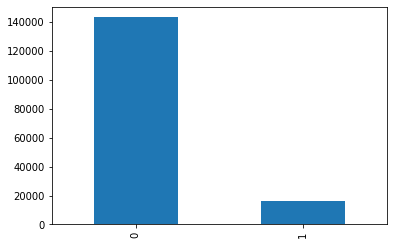

In [12]:
target.value_counts().plot(kind='bar')

It is seen that target is not balanced, so we use the stratify parameter when dividing into test and train samples.

In [13]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size =  0.10, random_state = 42,
                                                                            stratify = target)



In [14]:
features_train.head(3)

,text_lemm
81604,March UTC That s some strange interpretation ...
78427,style background color F FFFA padding cellpad...
55376,You Republic of Turkey and supporters therof a...


In [15]:
corpus_train = features_train['text_lemm'].values.astype('U')
corpus_test = features_test['text_lemm'].values.astype('U')

In [16]:
tfidf_vectorizer = TfidfVectorizer(stop_words = stop_words, max_features=10000)

vect_train = tfidf_vectorizer.fit_transform(corpus_train)
vect_test = tfidf_vectorizer.transform(corpus_test)


max_features was selected experimentally, increasing it to 15-20 thousand, the metric did not change, by reducing it to less than 10 thousand, the metric worsened deteriorated.

In [17]:
feature_names = tfidf_vectorizer.get_feature_names()
f = pd.DataFrame(vect_train.toarray(), columns = feature_names)
f.head()

,aa,aaron,ab,abandon,abandoned,abbey,abbreviation,abbreviations,abc,abdul,...,zealand,zero,zinc,zionism,zionist,zionists,zoe,zone,zoo,zuck
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Training

### 2.1 Logistic regression

Since the target is unbalanced, it's necessary to specify this in model hyperparamenters.

In [18]:
lr_model = LogisticRegression(class_weight= {0:1,1:10}, random_state= 42, max_iter = 1000,
                              solver='liblinear')

In [19]:
lr_model.fit(vect_train, target_train)


LogisticRegression(C=1.0, class_weight={0: 1, 1: 10}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
predict = lr_model.predict(vect_test)
print(f1_score(target_test,predict))

0.7057026476578412


In [21]:
print('Confusion matrix')
print(confusion_matrix(target_test,predict))
print()

Confusion matrix
[[13416   919]
 [  237  1386]]



### 2.2 LightGBM

In [22]:
lgb_model = LGBMClassifier(random_state=42, class_weight= {0:1,1:8},learning_rate = 0.2,
                           n_estimators = 200)


In [23]:
light_distributions = dict(max_depth = [15,30], max_bin=[100,300])

In [24]:
light_rand_clf =RandomizedSearchCV(lgb_model, param_distributions =light_distributions ,scoring='f1', n_jobs= -1,
                   cv=3,random_state= 42, n_iter = 4)

In [25]:
light_rand_clf.fit(vect_train, target_train)
print(light_rand_clf.best_params_)
print(light_rand_clf.best_score_)

{'max_depth': 15, 'max_bin': 300}
0.7607984883997331


In [26]:
lgb_model = LGBMClassifier(random_state=42, class_weight= {0:1,1:8},learning_rate = 0.5,
                           n_estimators = 300, max_depth = 15, max_bin = 100)


In [27]:
lgb_model.fit(vect_train, target_train)
predictions_lgb = lgb_model.predict(vect_test)
print(f1_score(target_test,predictions_lgb))

0.751338488994646


In [28]:
print('Confusion matrix')
print(confusion_matrix(target_test,predictions_lgb))
print()

Confusion matrix
[[13859   476]
 [  360  1263]]



# 3. Conclusion

After many attempts to process the text and improve the metrics, I came to the conclusion that lemmatisation did not play a significant role in processing comments. Perhaps when processing plain text, where all words are used in the correct form, lemmarisation would have played a greater role. In toxic comments there are many extra letters used, words are misspelled : it is more important to use these words as they are. Lemmatisation by part of speech takes a very long time, so if it is possible not to use it, I would do that.

In the same way, attempts to limit the vectorizer have not been successful: by limiting the upper or lower boundary of the most used words, we exclude words that have proven important to the model to determine whether or not they are toxic comments.   
Limiting the number of features had the following effect: allocating less than 10,000 worsened the metric and  increased the model's running time. 

Two models were tested: logistic regression and LightGBM. The best result was achieved by the LightGBM model: F1 score 0.75. LightGBM model has found slightly less toxic comments, but it was two times less false positive comments than Logistic regression. It seems to me that the online shop also needs to decide what is more important: is it worth catching all toxic comments at expense of having too much false positive comments or not. 